# Assignment 1

This code baseline is inspired by and modified from [this great tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

This code can achieve an accuracy of approximately 86.50% on CIFAR-10. Please set up the environment and run your experiments starting from this baseline. You are expected to achieve an accuracy higher than this baseline.

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms


import matplotlib.pyplot as plt

In [2]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 128
batch_size = 256
num_workers = 2
print_every = 200

optim_name = "Adam"
optim_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-6,
)


# preprocessing pipeline for input images
transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    transformation[data_type] = tv_transforms.Compose(([
        tv_transforms.RandomRotation(degrees=15),
        tv_transforms.RandomHorizontalFlip(),
        tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ] if is_train else []) + 
    [
        tv_transforms.ToTensor(),
        tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])


In [3]:
from datasets import load_dataset, Image 
from torch.utils.data import Dataset
import os
import torch

class HuggingFaceWrapper(Dataset):
    """一个适配器类，使Hugging Face数据集与torchvision的(img, target)格式兼容"""
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        

        img = sample['image']
        target = sample['label']
        img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target


local_data_dir = "./imagenet/data" 

data_files = {
    "train": os.path.join(local_data_dir, "train-00000-of-00001-1359597a978bc4fa.parquet"),
    "valid": os.path.join(local_data_dir, "valid-00000-of-00001-70d52db3c749a935.parquet")
}

print(f"正在从本地 Parquet 文件 {local_data_dir} 加载 tiny-imagenet...")

hf_datasets = load_dataset(
    "parquet",
    data_files=data_files
)


print("正在转换 'image' 列为 Image 格式...")
hf_datasets = hf_datasets.cast_column("image", Image())
print("转换完成。")


hf_dataset_train = hf_datasets['train']
hf_dataset_val = hf_datasets['valid'] 
print("数据集加载完成。")


dataset, loader = {}, {}

dataset["train"] = HuggingFaceWrapper(hf_dataset_train, transform=transformation['train'])
dataset["test"] = HuggingFaceWrapper(hf_dataset_val, transform=transformation['test'])


for data_type in ("train", "test"):
    is_train = data_type=="train"
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )

print("DataLoader 创建完成。")

正在从本地 Parquet 文件 ./imagenet/data 加载 tiny-imagenet...
正在转换 'image' 列为 Image 格式...
转换完成。
数据集加载完成。
DataLoader 创建完成。


In [4]:
# 深  宽

net = nn.Sequential(
    # Block 1: Input (3, 32, 32) -> Output (64, 16, 16)
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Block 2: Input (64, 16, 16) -> Output (128, 8, 8)
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Block 3: Input (128, 8, 8) -> Output (256, 4, 4)
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Block 4: Input (256, 4, 4) -> Output (512, 2, 2)
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    nn.Flatten(),

    # Classifier
    nn.Linear(512 * 4 * 4, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 200),
)

In [5]:
# our network architecture
# net = nn.Sequential(
#     nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
#     nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
#     nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Flatten(),
#     nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(128, 10),
# )

# move to device
net.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 58.80M


## Start Training

[epoch=  1, iter=  200] loss: 5.070
[Epoch   1] Validation loss: 4.319, Accuracy: 7.67%
[epoch=  2, iter=  200] loss: 4.213
[Epoch   2] Validation loss: 3.734, Accuracy: 16.42%
[epoch=  3, iter=  200] loss: 3.747
[Epoch   3] Validation loss: 3.350, Accuracy: 22.16%
[epoch=  4, iter=  200] loss: 3.433
[Epoch   4] Validation loss: 3.158, Accuracy: 25.92%
[epoch=  5, iter=  200] loss: 3.220
[Epoch   5] Validation loss: 3.003, Accuracy: 28.82%
[epoch=  6, iter=  200] loss: 3.035
[Epoch   6] Validation loss: 2.833, Accuracy: 32.31%
[epoch=  7, iter=  200] loss: 2.882
[Epoch   7] Validation loss: 2.763, Accuracy: 33.33%
[epoch=  8, iter=  200] loss: 2.745
[Epoch   8] Validation loss: 2.659, Accuracy: 36.40%
[epoch=  9, iter=  200] loss: 2.616
[Epoch   9] Validation loss: 2.621, Accuracy: 37.80%
[epoch= 10, iter=  200] loss: 2.517
[Epoch  10] Validation loss: 2.560, Accuracy: 38.02%
[epoch= 11, iter=  200] loss: 2.435
[Epoch  11] Validation loss: 2.439, Accuracy: 40.51%
[epoch= 12, iter=  200

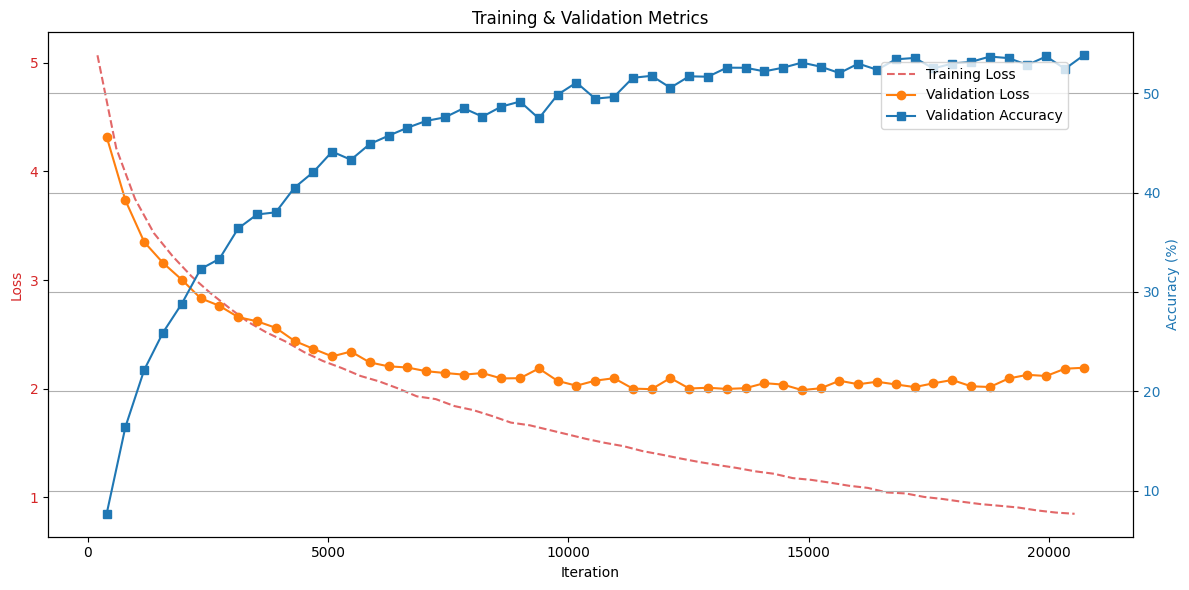

In [6]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# loss function
criterion = nn.CrossEntropyLoss()

loss_history = []
iter_history = []
current_iter = 0
val_loss_history = []
val_acc_history = []
val_iter_history = []
patience = 15 
epochs_no_improve = 0 
best_val_loss = float('inf')


# training loop
net.train()
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)


        pred = net(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        current_iter += 1
        if i % print_every == print_every - 1:
            avg_loss = running_loss / print_every
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            iter_history.append(current_iter)
            loss_history.append(avg_loss)
            running_loss = 0.0

    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img, target in loader["test"]:
            img, target = img.to(device), target.to(device)
            pred = net(img)
            loss = criterion(pred, target)
            val_loss += loss.item()
            total += len(target)
            correct += (torch.argmax(pred, dim=1) == target).sum().item()

    avg_val_loss = val_loss / len(loader["test"])
    accuracy = 100 * correct / total

    print(f"[Epoch {epoch + 1:3d}] Validation loss: {avg_val_loss:.3f}, Accuracy: {accuracy:.2f}%")
    val_iter_history.append(current_iter)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(accuracy)
    # 早停
    if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\\nEarly stopping triggered after {patience} epochs without improvement.")
        break 


print("Finished Training")
# 画图
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Training & Validation Metrics')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(iter_history, loss_history, color='tab:red', linestyle='--', alpha=0.7, label='Training Loss')
ax1.plot(val_iter_history, val_loss_history, color='tab:orange', marker='o', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(val_iter_history, val_acc_history, color='tab:blue', marker='s', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

fig.tight_layout()
plt.grid(True)
plt.savefig('all_metrics_curve.png')

## Evaluating its accuracy

In [7]:
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)
        
        # make prediction
        pred = net(img)
        
        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 53.83%
